<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Snow-Depth-3022" data-toc-modified-id="Snow-Depth-3022-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Snow Depth 3022</a></span><ul class="toc-item"><li><span><a href="#Test---Performance" data-toc-modified-id="Test---Performance-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test - Performance</a></span></li><li><span><a href="#Overall---Performance" data-toc-modified-id="Overall---Performance-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Overall - Performance</a></span></li><li><span><a href="#Explainability" data-toc-modified-id="Explainability-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Explainability</a></span><ul class="toc-item"><li><span><a href="#Panel-Temperature" data-toc-modified-id="Panel-Temperature-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Panel Temperature</a></span></li><li><span><a href="#Hour-of-Day" data-toc-modified-id="Hour-of-Day-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Hour of Day</a></span></li></ul></li></ul></li></ul></div>

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.insert(1, '../src/data')

In [6]:
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix 
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance, plot_partial_dependence

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

from xml2dict import *
from dict2tabular import *

We use a subset of the data where any QA test has failed, to then filter to only those which failed the QA test for our target variable. 

In [ ]:
df_qa_failed = read_pickle(file='../data/processed/df_complete_qa_not_passed.pickle')

In [ ]:
def qa_failed_to_ml_input(target_var: str, df_qa_failed):
    if not isinstance(df_qa_failed, pd.DataFrame):
        df_qa_failed = read_pickle(file='../data/processed/df_complete_qa_not_passed.pickle')
    
    df_ml = create_target_variable(df=df_qa_failed,
                                   var_list=[target_var], 
                                   qa_false_negative=False,
                                   qa_false_positive=False)
    # Delete information not available at prediction time and sensors without meaning (dummy/deactivated)
    cols = list(df_ml.columns)
    cols = [col for col in cols if all(substring not in col for substring in ['post_mc', 
                                                                              'orig-value', 
                                                                              'override', 
                                                                              'dummy', 
                                                                              'deactivated'])]
    df_ml = df_ml[cols].copy()
    
    # Primary goal is to reduce the number of checks which have to be done during manuel correction therefore we focus on the false negatives
    failed_qa_cond = (df_ml[target_var+'_overall_qa_summary']!='100') & (df_ml[target_var+'_overall_qa_summary'].notnull()) 
    df_ml = df_ml[failed_qa_cond].copy()
    
    return df_ml

In [6]:
%%time 
target_var = 'snow_depth_3022'
df_ml = qa_failed_to_ml_input(target_var=target_var, df_qa_failed=df_qa_failed)

CPU times: user 33.1 s, sys: 3min 39s, total: 4min 12s
Wall time: 9min 37s


In [7]:
def convert_datatypes(df_ml):
    auto_qa_result_cols = get_sublist_containing_string(input_list=list(df_ml.columns), substrings='_qa')
    measurement_value_cols = get_sublist_containing_string(input_list=list(df_ml.columns), substrings='_value')
    derived_value_cols = get_sublist_containing_string(input_list=list(df_ml.columns), substrings='-derived')
    
    stations_categorical = ['tc_identifier']
    station_characteristics = ['latitude', 'longitude', 'station_elevation']
    time_cols = ['date_time']

    floating = station_characteristics + measurement_value_cols + derived_value_cols + auto_qa_result_cols
    datetime = time_cols
    categorical = stations_categorical
    
    for num_col in floating:
        df_ml.loc[:, num_col] = pd.to_numeric(df_ml[num_col], errors='coerce')
     
    for cat_col in categorical:
        df_stations_dummy = pd.get_dummies(df_ml.tc_identifier, prefix="station")
        df_ml = pd.concat([df_stations_dummy, df_ml], axis=1) 
            
    for date in datetime:
        df_ml.loc[:, date] = pd.to_datetime(df_ml[date], errors='coerce')
        
    native_cols = get_sublist_containing_string(input_list=list(df_ml.columns), substrings='native')
    for col in native_cols:
        df_ml[col] = pd.to_numeric(df_ml[col].map({'N': 0, 'Y': 1}), errors='coerce')
    
    return df_ml.copy()

In [9]:
df_ml.dropna(how='all', axis=1, inplace=True)

In [10]:
df_ml.shape

(44373, 2689)

In [11]:
%%time
df_ml = convert_datatypes(df_ml)

CPU times: user 1h 3min 22s, sys: 3h 43min 23s, total: 4h 46min 46s
Wall time: 7h 13min 49s


In [13]:
save_pickle(folder_path='../data/processed/', file_name='df_snow_depth_3022', save_object=df_ml)

# Snow Depth 3022

We suspect that some types of events might be occuring only seasonal. To make it more likely that a sample of this event type is provided for the training set, we will use a **random sampling** method for the creation of our training and test set. Using this approach we have to be careful to avoid **information leakage** to the algorithm which normally isn't available at prediction time (e.g. a specific day were all values were changed). Therefore, we will not use the date information of day and month, but only the time in the day. 

In [4]:
target_var = 'snow_depth_3022'

In [5]:
X = read_pickle(file='../data/processed/df_snow_depth_3022.pickle')

In [7]:
# Add another feature for hour of the day
X['hour_of_day'] = X.date_time.dt.hour

# A lot of columns are mainly empty and we restrict ourselves to the complete columns
X = X.dropna(how='any', axis=1)

# Target Variable
y = X['snow_depth_3022_target']

# Drop all columns with information which should not be used during prediction
del_cols = ['origin_filename', 'station_time_identifier', 'tc_identifier','snow_depth_3022_target', 'date_time', 
            'station_name', 'version', 'correction', 'source_uri', 'station_identifier', '_merge']
X.drop(del_cols , axis = 1, inplace=True) 

**Class Imbalance**: We have a lot more samples where the automatic QA result was not changed then samples where the manual correction actually overturned the result. 

In [9]:
y.value_counts()

0    44297
1       76
Name: snow_depth_3022_target, dtype: int64

In [10]:
imbalance_score = y.mean()
imbalance_score

0.0017127532508507425

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
rfc_estimator = rfc(n_estimators=1000, 
                    min_samples_leaf=2, 
                    n_jobs=7)


sampler = ADASYN()
clf = make_pipeline(sampler, rfc_estimator)

In [13]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(n_jobs=None, n_neighbors=5, random_state=None,
                        sampling_strategy='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=7,
                                        oob_score=False, random_state=None,
                                        verbose=0, wa

In [14]:
save_pickle(folder_path= '../models/', file_name='random_forest_final_poc', save_object=rfc_estimator)

## Test - Performance

We verify how the performance is on unseen data. For that reason we have been holding back 20% of the data from the training.

In [ ]:
rfc_estimator = read_pickle(file='../models/random_forest_final_poc.pickle')

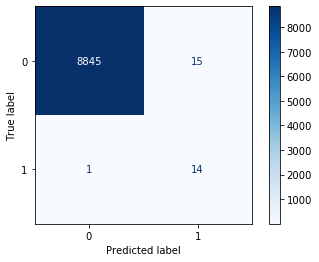

In [59]:
plot_confusion_matrix(rfc_estimator, X_test, y_test,
                      cmap=plt.cm.Blues, values_format='d')

The true label refers to whether (1) or not (0) the value was actually changed, and the predicted label reflects the prediction of the classification model. 

We can see that on unseen data **14 out of 15 actual changes (93%)** have been correctly predicted, which is called **recall** in Machine Learning terminology. On the other side is the so-called **precision** which is **14 out of 28 (50%)** in our case and gives the percentage of predicted changes which are actually changed. 

## Overall - Performance

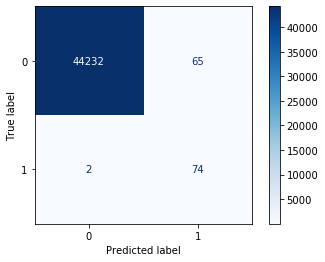

In [60]:
plot_confusion_matrix(rfc_estimator, X, y,
                      cmap=plt.cm.Blues, values_format='d')

The proportions of all four values are roughly identical which is another great observation in terms of the model quality. It means that the model is not overfitting to the data in has been seen during the training phase but actually identified patterns in the data which generalize well to the unseen data. 

## Explainability

In [61]:
def print_importances(X, estimator, threshold= 0.005):
    importances = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc_estimator.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        if importances[indices[f]]>threshold:
            print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

def plot_importances(X, estimator, threshold= 0.005):
    importances = estimator.feature_importances_
    num_relevant_features = (importances>threshold).sum()
    std = np.std([tree.feature_importances_ for tree in rfc_estimator.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    indices = indices[0:num_relevant_features]

    
    # Plot the feature importances of the forest
    plt.figure(figsize=(30,10))
    plt.title("Feature importances")
    plt.bar(range(num_relevant_features), importances[indices], color="#1F968BFF", yerr=std[indices], align="center")
    plt.xticks(range(num_relevant_features), X.columns[indices],rotation=90)
    plt.xlim([-1, num_relevant_features])
    plt.show()
    
print_importances(X=X, estimator=rfc_estimator, threshold= 0.005)

Feature ranking:
1. panel_temperature_1015_value (0.144438)
2. hour_of_day (0.114286)
3. snow_depth_3022_qa-temporal_summary (0.105447)
4. snow_depth_3024_qa-temporal_summary (0.094807)
5. snow_depth_3023_qa-temporal_summary (0.089230)
6. snow_depth_3022_qa-range_summary (0.044155)
7. snow_depth_3024_qa-range_summary (0.044047)
8. snow_depth_3023_qa-range_summary (0.037338)
9. longitude (0.029321)
10. latitude (0.024235)
11. snow_depth_3023_qa-integrity_summary (0.022541)
12. snow_depth_3023_qa-presence_summary (0.019663)
13. snow_depth_3022_qa-presence_summary (0.018965)
14. snow_depth_3022_qa-integrity_summary (0.018465)
15. station_WIC (0.017660)
16. station_elevation (0.017462)
17. snow_depth_3024_qa-presence_summary (0.017269)
18. snow_depth_3024_qa-integrity_summary (0.015610)
19. station_NGH (0.012137)
20. snow_depth_3024_overall_qa_summary (0.007938)
21. snow_depth_3022_overall_qa_summary (0.007677)
22. snow_depth_3024_native-suppressed (0.007233)
23. snow_depth_3022_native-sup

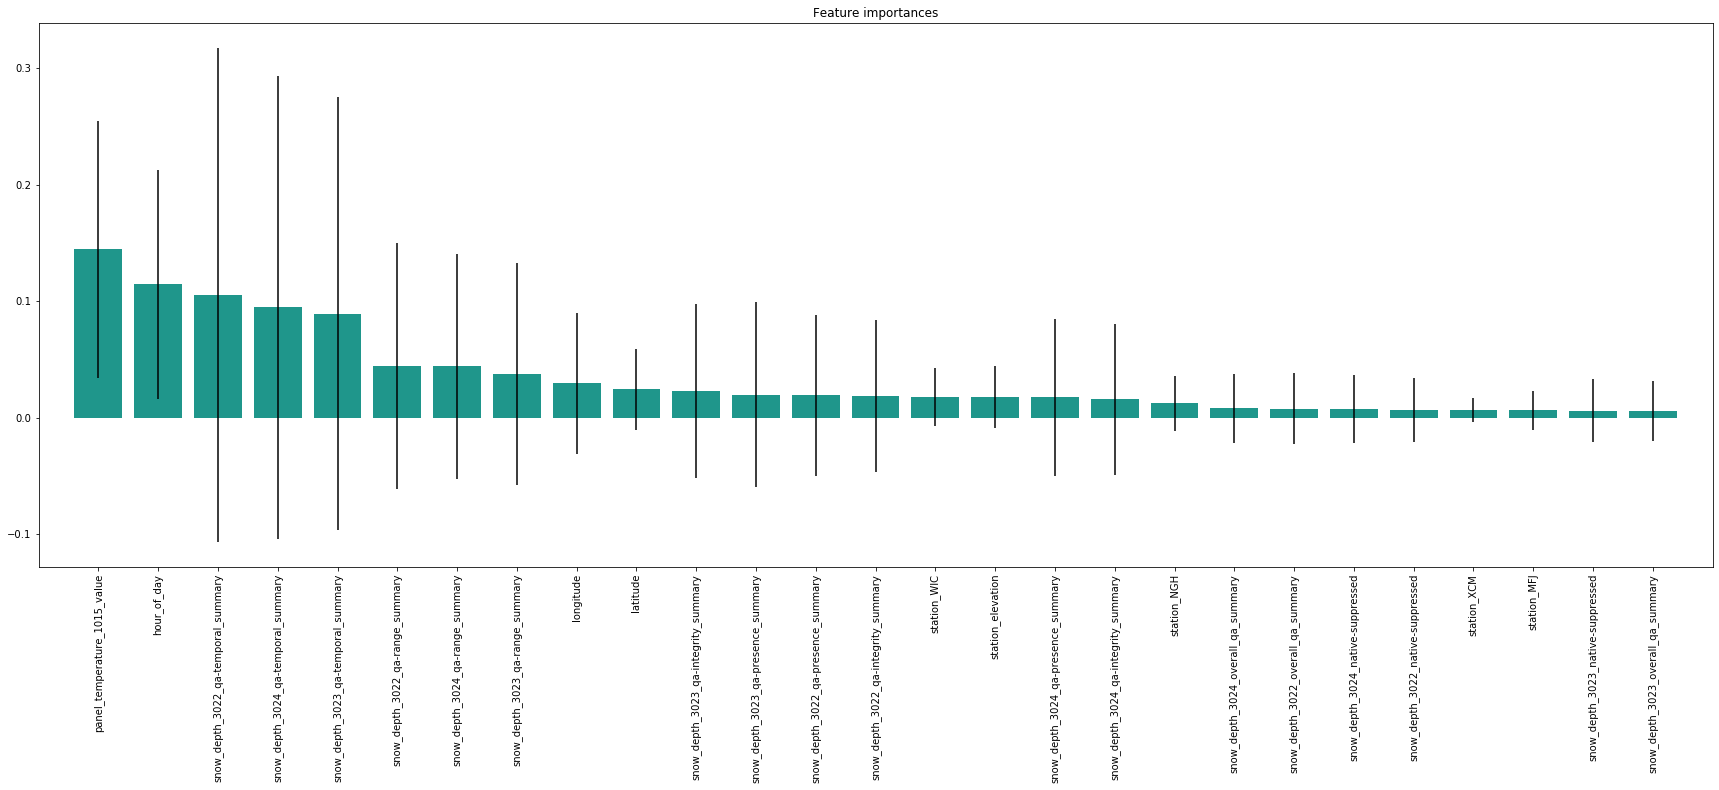

In [62]:
plot_importances(X=X, estimator=rfc_estimator, threshold= 0.005)

### Panel Temperature

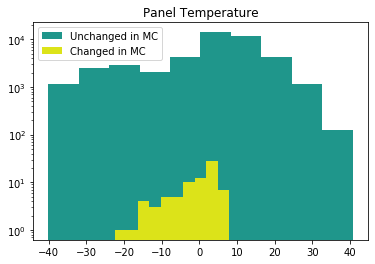

In [63]:
df = pd.concat([y, X], axis=1)
def plot_variable_target_hist(df, variable, title, target, log_scale=True):
    """ Plots the distribution of values of a variable for both classes of the target variable.
    
    Params:
        df (pd.DataFrame) - DataFrame containing the target variables and the 
    
    """
    plt.viridis()
    plt.hist(df[df[target]==False][variable].reset_index(drop=True), alpha=1, color='#1F968BFF', label="Unchanged in MC")
    plt.hist(df[df[target]==True][variable].reset_index(drop=True), color='#DCE319FF', label="Changed in MC")
    if log_scale:
        plt.yscale('log')
    plt.title(title)
    plt.legend()
    plt.show()
    
target = "snow_depth_3022_target"
variable = "panel_temperature_1015_value"
title = 'Panel Temperature'

plot_variable_target_hist(df, variable,title, target, log_scale=True)

We can see that there is an interaction between the panel temperature range and the likelihood that a value has been changed during the manual correction. While the panel temperature varies between -40 and 40 degrees all the changes during manual correction are related to cases where the temperature was between -22 and 8 degrees. 

Additionally, we can use partial dependency plots to investigate the importance the model on average assign to a certain panal temperature. In this case (classification) it shows how much it affects the probability that a sample is classified as 'manually corrected'. 

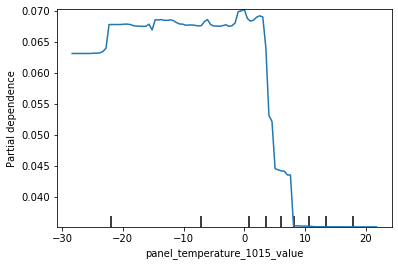

In [71]:
plot_partial_dependence(rfc_estimator, 
                        X, 
                        ['panel_temperature_1015_value'],
                       n_jobs=7)

It can be seen that it effects the probability by 0.06-0.07 as long as the panel temperature is below 2-3 degrees and then afterwards has no real influence anymore. Given that the threshold for classifying the sample (as belonging to the samples which were changed) is at 0.5, it means that for low panel temperatures up to 14% of the final decision might be based on the panel temperature.  

### Hour of Day

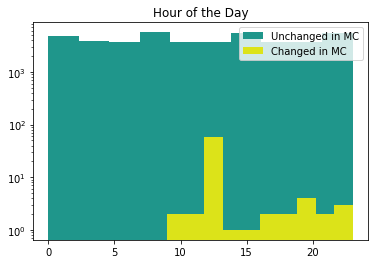

In [64]:
plot_variable_target_hist(df, 'hour_of_day', "Hour of the Day", target, log_scale=True)

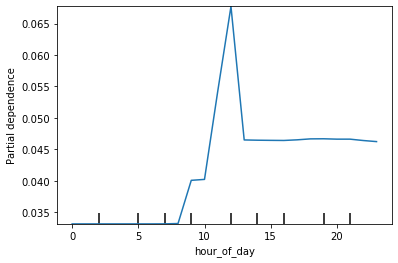

In [72]:
plot_partial_dependence(rfc_estimator, 
                        X, 
                        ['hour_of_day'],
                       n_jobs=7)